# MLP for error type prediction




In [1]:
import numpy as np
np.random.seed(123)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt

### Defining the Hyper-parameters

We now define the hyperparameters, the data `batch_size`, the training `learning_rate`, and others.

In [2]:
# Let's define some hyper-parameters
# num_inputs = 37 as we will have 37 columns
# num_classes = 3 as the classes of the variable we want to predict
hparams = {
    'batch_size':200,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':3,
    'num_inputs':37,
    'learning_rate':1e-4,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'


### Defining the PyTorch Dataset and the DataLoader

The PyTorch Dataset is an inheritable `class` that helps us defining what source of data do we have (image, audio, text, ...) and how to load it (overriding the `__getitem__` function). 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sonar = pd.read_csv('/content/drive/MyDrive/TAED2/sonar.csv')
sonar

,key,ISSUE_KEY,TYPE,SEVERITY,RESOLUTION,DEBT,MESSAGE,START_OFFSET,END_OFFSET,FIXING_TIME,project_id,complexity,file_complexity,duplicated_lines,duplicated_blocks,duplicated_files,duplicated_lines_density,violations,blocker_violations,critical_violations,major_violations,minor_violations,info_violations,open_issues,missing_package_info,development_cost,sqale_debt_ratio,new_sqale_debt_ratio,code_smells,bugs,reliability_remediation_effort,reliability_rating,vulnerabilities,security_remediation_effort,security_rating,lines,ncloc,ncloc_language_distribution,classes,files,directories,functions,statements,comment_lines,comment_lines_density
0,AWd6nb73C4KKKThc_A3s,AWd6nekaC4KKKThc_A33,CODE_SMELL,MAJOR,FIXED,5.0,Add a nested comment explaining why this metho...,16.0,29.0,490 days 05:26:52,org.apache:cayenne,25889.0,12.0,15116,1493,322,5.2,13163,105,536,6406,5753,363,13163,185,5174850,3.5,0.428380,11613,1438,12508,5,112,1745,4,288771.0,172495.0,"css=236,java=143648,web=14225,xml=14386",2264.0,2355.0,428.0,13879.0,65151.0,21363.0,11.0
1,AWd6tZbeC4KKKThc_By1,AWd6tcxLC4KKKThc_BzZ,BUG,CRITICAL,FIXED,30.0,"Make ""embeddablesMap"" transient or serializable.",22.0,36.0,300 days 05:19:50,org.apache:cayenne,25932.0,12.0,15116,1493,322,5.2,13164,105,538,6405,5754,362,13164,185,5181360,3.5,0.231766,11612,1440,12568,5,112,1745,4,289183.0,172712.0,"css=236,java=143885,web=14225,xml=14366",2268.0,2359.0,428.0,13910.0,65268.0,21389.0,11.0
2,AWd6zCYKC4KKKThc_E2z,AWeFbxElC4KKKThcA-bK,CODE_SMELL,MAJOR,FIXED,90.0,Lazy class,0.0,66.0,220 days 04:16:14,org.apache:cayenne,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,"css=236,java=144245,web=14225,xml=14391",2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
3,AWd6zCYKC4KKKThc_E2z,AWeHCUklC4KKKThcBPfg,CODE_SMELL,MAJOR,FIXED,90.0,Lazy class,0.0,66.0,275 days 01:44:09,org.apache:cayenne,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,"css=236,java=144245,web=14225,xml=14391",2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
4,AWd6zCYKC4KKKThc_E2z,AWd-kQ1gC4KKKThc_2XC,CODE_SMELL,MAJOR,FIXED,90.0,Lazy class,0.0,66.0,153 days 06:21:48,org.apache:cayenne,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,"css=236,java=144245,web=14225,xml=14391",2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697597,AWMdGfe8O48jNFNDDtun,AWMdGgFQO48jNFNDDtzK,CODE_SMELL,MINOR,FIXED,1.0,"At most one statement is allowed per line, but...",0.0,109.0,14 days 18:35:48,org.apache:zookeeper,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,"java=62021,web=884,xml=2869",772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697598,AWMdGfe8O48jNFNDDtun,AWMdGgFRO48jNFNDDtzM,CODE_SMELL,MINOR,FIXED,1.0,"At most one statement is allowed per line, but...",0.0,39.0,14 days 18:35:48,org.apache:zookeeper,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,"java=62021,web=884,xml=2869",772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697599,AWMdGfe8O48jNFNDDtun,AWMdGgFRO48jNFNDDtzO,CODE_SMELL,MINOR,FIXED,1.0,"At most one statement is allowed per line, but...",0.0,70.0,14 days 18:35:48,org.apache:zookeeper,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,"java=62021,web=884,xml=2869",772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697600,AWMdGfe8O48jNFNDDtun,AWMdGgFRO48jNFNDDtzP,CODE_SMELL,MINOR,FIXED,90.0,Complex class,0.0,3.0,14 days 18:35:48,org.apache:zookeeper,9739.0,20.9,4870,311,101,4.9,4836,18,5

In [5]:
sonar_num = sonar.loc[:,~sonar.columns.isin(["key","ISSUE_KEY","SEVERITY","RESOLUTION","MESSAGE","project_id","ncloc_language_distribution"])]
sonar_num

,TYPE,DEBT,START_OFFSET,END_OFFSET,FIXING_TIME,complexity,file_complexity,duplicated_lines,duplicated_blocks,duplicated_files,duplicated_lines_density,violations,blocker_violations,critical_violations,major_violations,minor_violations,info_violations,open_issues,missing_package_info,development_cost,sqale_debt_ratio,new_sqale_debt_ratio,code_smells,bugs,reliability_remediation_effort,reliability_rating,vulnerabilities,security_remediation_effort,security_rating,lines,ncloc,classes,files,directories,functions,statements,comment_lines,comment_lines_density
0,CODE_SMELL,5.0,16.0,29.0,490 days 05:26:52,25889.0,12.0,15116,1493,322,5.2,13163,105,536,6406,5753,363,13163,185,5174850,3.5,0.428380,11613,1438,12508,5,112,1745,4,288771.0,172495.0,2264.0,2355.0,428.0,13879.0,65151.0,21363.0,11.0
1,BUG,30.0,22.0,36.0,300 days 05:19:50,25932.0,12.0,15116,1493,322,5.2,13164,105,538,6405,5754,362,13164,185,5181360,3.5,0.231766,11612,1440,12568,5,112,1745,4,289183.0,172712.0,2268.0,2359.0,428.0,13910.0,65268.0,21389.0,11.0
2,CODE_SMELL,90.0,0.0,66.0,220 days 04:16:14,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
3,CODE_SMELL,90.0,0.0,66.0,275 days 01:44:09,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
4,CODE_SMELL,90.0,0.0,66.0,153 days 06:21:48,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697597,CODE_SMELL,1.0,0.0,109.0,14 days 18:35:48,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697598,CODE_SMELL,1.0,0.0,39.0,14 days 18:35:48,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697599,CODE_SMELL,1.0,0.0,70.0,14 days 18:35:48,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697600,CODE_SMELL,90.0,0.0,3.0,14 days 18:35:48,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2


In [6]:
# convert fixing time to days with decimal part.
from datetime import datetime
sonar_num["FIXING_TIME"] = pd.to_timedelta(sonar_num['FIXING_TIME']).astype('timedelta64[s]')/86400
sonar_num

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TYPE,DEBT,START_OFFSET,END_OFFSET,FIXING_TIME,complexity,file_complexity,duplicated_lines,duplicated_blocks,duplicated_files,duplicated_lines_density,violations,blocker_violations,critical_violations,major_violations,minor_violations,info_violations,open_issues,missing_package_info,development_cost,sqale_debt_ratio,new_sqale_debt_ratio,code_smells,bugs,reliability_remediation_effort,reliability_rating,vulnerabilities,security_remediation_effort,security_rating,lines,ncloc,classes,files,directories,functions,statements,comment_lines,comment_lines_density
0,CODE_SMELL,5.0,16.0,29.0,490.226991,25889.0,12.0,15116,1493,322,5.2,13163,105,536,6406,5753,363,13163,185,5174850,3.5,0.428380,11613,1438,12508,5,112,1745,4,288771.0,172495.0,2264.0,2355.0,428.0,13879.0,65151.0,21363.0,11.0
1,BUG,30.0,22.0,36.0,300.222106,25932.0,12.0,15116,1493,322,5.2,13164,105,538,6405,5754,362,13164,185,5181360,3.5,0.231766,11612,1440,12568,5,112,1745,4,289183.0,172712.0,2268.0,2359.0,428.0,13910.0,65268.0,21389.0,11.0
2,CODE_SMELL,90.0,0.0,66.0,220.177940,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
3,CODE_SMELL,90.0,0.0,66.0,275.072326,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
4,CODE_SMELL,90.0,0.0,66.0,153.265139,25981.0,12.0,15116,1493,322,5.2,13194,105,538,6419,5755,377,13194,187,5192910,3.5,1.068211,11642,1440,12568,5,112,1745,4,289877.0,173097.0,2275.0,2365.0,430.0,13949.0,65404.0,21443.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697597,CODE_SMELL,1.0,0.0,109.0,14.774861,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697598,CODE_SMELL,1.0,0.0,39.0,14.774861,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697599,CODE_SMELL,1.0,0.0,70.0,14.774861,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2
697600,CODE_SMELL,90.0,0.0,3.0,14.774861,9739.0,20.9,4870,311,101,4.9,4836,18,522,2122,2105,69,4836,25,1973220,3.1,2.176649,4363,32,177,5,441,10795,4,99208.0,65774.0,772.0,470.0,30.0,4574.0,31057.0,10010.0,13.2


In [7]:
#transform the 'TYPE' variable to numerical
sonar_num['TYPE'] = sonar_num['TYPE'].replace(['CODE_SMELL'],0)
sonar_num['TYPE'] = sonar_num['TYPE'].replace(['BUG'],1)
sonar_num['TYPE'] = sonar_num['TYPE'].replace(['VULNERABILITY'],2)
sonar_num["TYPE"].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

array([0, 1, 2])

In [8]:
sonar_num.to_csv('/content/drive/MyDrive/TAED2/sonar_nn.csv',index = False, header=True)

In [9]:
class Dataset(object):
   
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [10]:
class DT(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #the target variable (label) is the first column in the 'data' dataset 
        image = self.data.iloc[index, 1:].values.astype(np.float32)
        label = self.data.iloc[index, 0]
        

#['CODE_SMELL']   ,0
#['BUG']          ,1
#['VULNERABILITY'],2 
       
        #label = torch.nn.functional.one_hot(torch.Tensor(self.data.iloc[index, 0]).to(torch.int64), 3)
        #to retrive the labels do: torch.argmax(one_hot, dim=1).

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [11]:
sonar_nn = DT('/content/drive/MyDrive/TAED2/sonar_nn.csv', transform=None)

In [12]:

train_size = int(0.7 * len(sonar_nn))
test_size = len(sonar_nn) - train_size
trainset, testset = torch.utils.data.random_split(sonar_nn, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hparams['batch_size'],
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=hparams['test_batch_size'],
                                         shuffle=False)


# Training  the Multi-Layer Perceptron (MLP)

Defining the neural network.

It has one hidden layer and uses LogSoftmax to prdict the classes.


In [13]:

network = nn.Sequential(
    nn.Linear(hparams['num_inputs'],hparams['hidden_size']),
    nn.ReLU(),
    nn.Linear(hparams['hidden_size'],hparams['num_classes']),
    nn.LogSoftmax(),
)

# Send the network to the proper device (CPU or GPU)
network.to(hparams['device'])

Sequential(
  (0): Linear(in_features=37, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=3, bias=True)
  (3): LogSoftmax(dim=None)
)

In [14]:
#Function to check the parameters of the network
def get_nn_nparams(net):
  """ https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6 """
  pp=0
  for p in list(net.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  return pp
  
print(network)
print('Num params: ', get_nn_nparams(network))

Sequential(
  (0): Linear(in_features=37, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=3, bias=True)
  (3): LogSoftmax(dim=None)
)
Num params:  5251


Defining loss function, optimizer, and metrics





In [15]:

import torch.optim as optim
import torch.nn.functional as F

# loss function
criterion = F.nll_loss

# optimizer (Root Mean Square propagation)
optimizer = optim.RMSprop(network.parameters(),lr=hparams['learning_rate'])

# Define the Accuracy metric in the function below by:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item() # sum all correct predictions for the batch
  return acum

Defining the training and test for en epoch procedures.

In [16]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):

  # Activate the train=True flag inside the model
  network.train()
  
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1

  # For each batch
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      
      data = data.view(data.shape[0],-1)
      output = torch.Tensor(network(data))
    
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [17]:
def test_epoch(test_loader, network, hparams):

    # Dectivate the train=True flag inside the model
    network.eval()
    
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:

            # Load data and feed it through the neural network
            data, target = data.to(device), target.to(device)
            
            # Optain network predictions
            data = data.view(data.shape[0],-1)
            output = network(data)

            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss

            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)

    # Average accuracy across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

Loop to train the network for as many epochs as desired and save the train and test losses for every epoch.

In [18]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
test_accs = []

# For each epoch
for epoch in range(1, hparams['num_epochs'] + 1):

  # Compute & save the average training loss for the current epoch
  train_loss = train_epoch(train_loader, network, optimizer, criterion, hparams)
  train_losses.append(train_loss)

  # Compute & save the average test loss & accuracy for the current epoch
  test_loss, test_accuracy = test_epoch(test_loader,network,hparams)  
  test_losses.append(test_loss)
  test_accs.append(test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/488321 (0%)]	Loss: 12326.672852
Train Epoch: 1 [20000/488321 (4%)]	Loss: 3076.198242
Train Epoch: 1 [40000/488321 (8%)]	Loss: 1915.730835
Train Epoch: 1 [60000/488321 (12%)]	Loss: 961.474243
Train Epoch: 1 [80000/488321 (16%)]	Loss: 1534.398560
Train Epoch: 1 [100000/488321 (20%)]	Loss: 1298.833496
Train Epoch: 1 [120000/488321 (25%)]	Loss: 865.776001
Train Epoch: 1 [140000/488321 (29%)]	Loss: 743.817139
Train Epoch: 1 [160000/488321 (33%)]	Loss: 1623.572632
Train Epoch: 1 [180000/488321 (37%)]	Loss: 2577.463135
Train Epoch: 1 [200000/488321 (41%)]	Loss: 845.604126
Train Epoch: 1 [220000/488321 (45%)]	Loss: 1524.324951
Train Epoch: 1 [240000/488321 (49%)]	Loss: 1026.074585
Train Epoch: 1 [260000/488321 (53%)]	Loss: 4587.089355
Train Epoch: 1 [280000/488321 (57%)]	Loss: 790.926270
Train Epoch: 1 [300000/488321 (61%)]	Loss: 2552.677490
Train Epoch: 1 [320000/488321 (66%)]	Loss: 2655.366943
Train Epoch: 1 [340000/488321 (70%)]	Loss: 2457.258789
Train Epoch: 1 [360000/488

Do a plot of the train and test losses to evaluate the behavior of the netwwork. 

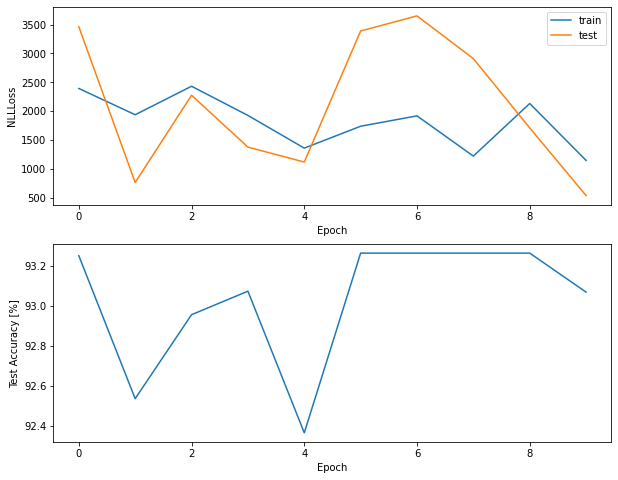

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs)